In [2]:
import cPickle
import glob
import gzip
import os
import random
import shutil
import subprocess
import uuid

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
import seaborn as sns
import statsmodels.api as sm

import ciepy as cpy
import projectpy as ppy

%matplotlib inline
%load_ext rpy2.ipython

random.seed(20150605)

In [3]:
outdir = os.path.join(cpy.root, 'output',
                      'eqtl_input')
ppy.makedir(outdir)

private_outdir = os.path.join(cpy.root, 'private_output',
                              'eqtl_input')
ppy.makedir(private_outdir)

In [9]:
array_meta = pd.read_table(os.path.join(cpy.root, 'data', 'array_metadata.tsv'), index_col=0)
wgs_meta = pd.read_table(os.path.join(cpy.root, 'data', 'wgs_metadata.tsv'), index_col=0, 
                         squeeze=True)
rna_meta = pd.read_table(os.path.join(cpy.root, 'data', 'rna_seq_metadata.tsv'), index_col=0)

fn = os.path.join(cpy.root, 'private_data', 'TableOf280_PedigreeWithUUIDS_forPhasing_V2.xlsx')
pedigree = pd.read_excel(fn)
pedigree.index = pedigree['ID']

gene_counts = pd.read_table(os.path.join(cpy.root, 'data', 'gene_counts.tsv'),
                            index_col=0)
gene_info = pd.read_table('/raid3/projects/CARDIPS/data/public/gencode_v19/gene_info.tsv',
                          index_col=0)
genes = pbt.BedTool('/raid3/projects/CARDIPS/data/public/gencode_v19/genes.bed')

In [10]:
%%R

suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library("BiocParallel"))
register(MulticoreParam(30))

# Gene Expression

I'll make normalized counts from DESeq and VST counts. I'll also get counts from RSEM.

## Naive Counts: Library Normalized and VST

In [11]:
gene_counts_f = gene_counts[gene_counts.sum(axis=1) > 0]
gene_counts_f = gene_counts_f[gene_counts_f.median(axis=1) > 50]
gene_counts_f = gene_counts_f[gene_info.ix[gene_counts_f.index, 'gene_type'] == 'protein_coding']

In [12]:
tmeta = rna_meta[['subject', 'passage', 'flowcell']]
index = tmeta.index
genes = gene_counts_f.index
counts = gene_counts_f

In [13]:
%%R -i outdir,counts,tmeta,index,genes

rownames(tmeta) = index
rownames(counts) = genes

# make DESeq data set
dds = DESeqDataSetFromMatrix(
    countData = counts, colData = tmeta, 
    design = ~ subject
    )

dds = estimateSizeFactors(dds)

write.table(counts(dds, normalized=TRUE), 
            file=paste(outdir, "norm_counts.tsv", sep="/"),
            quote=FALSE, col.names=NA, sep="\t")

vsd = varianceStabilizingTransformation(dds)

write.table(assay(vsd), 
            file=paste(outdir, "vst_counts.tsv", sep="/"),
            quote=FALSE, col.names=NA, sep="\t")

In [14]:
vsd = pd.read_table(os.path.join(outdir, 'vst_counts.tsv'), index_col=0)

## RSEM

TODO

# Variant Regions

I'm going to identify the regions within 1 megabase of the TSSs for each gene whose
variants I want to test.

In [85]:
fn = os.path.join(outdir, 'variant_regions.bed')
if not os.path.exists(fn):
    variant_regions = cpb.gencode.make_promoter_bed(ppy.gencode_gtf, merge_by_gene=True,
                                                   up=1000000, down=1000000, out=fn)
else:
    variant_regions = pbt.BedTool(fn)

In principle, there could be multiple regions per gene if a gene has TSSs located more than
1MB apart. In practice, this doesn't seem to happen.

In [96]:
gene_to_regions = dict()
for r in variant_regions:
    gene = r.name.split('_')[0]
    gene_to_regions[gene] = gene_to_regions.get(gene, []) + ['{}:{}-{}'.format(
            r.chrom, r.start, r.end)]
fn = os.path.join(outdir, 'gene_to_regions.p')
cPickle.dump(gene_to_regions, open(fn, 'wb') )

In [ ]:
3 + 

# Make PED File

The first six columns of the ped file are

     Family ID
     Individual ID
     Paternal ID
     Maternal ID
     Sex (1=male; 2=female; other=unknown)
     Phenotype
     
I'll have to use the WGS UUIDs for the PED file so the phenotypes are matched with the genotypes.

In [17]:
f = gzip.open(os.path.join(cpy.root, 'private_data', 'wgs', 'merged_pass_uuid_ann_ref.vcf.gz'))
line = f.readline().strip()
while line[1] == '#':
    line = f.readline().strip()
f.close()
wgs_ids = line.split('\t')[9:]

rna_meta = rna_meta.merge(pedigree, left_on='subject', right_index=True, how='left')

vals = []
fam_id = 42
for i in vsd.columns:
    r = rna_meta.ix[i, ['FAMILY_ID', 'wgs_id', 'FATHER', 'MOTHER', 'sex', 'flowcell']]
    if pd.isnull(r['FAMILY_ID']):
        r['FAMILY_ID'] = 'Family_{}'.format(fam_id)
        fam_id += 1
    if r['FATHER'] == 0 or pd.isnull(r['FATHER']):
        r['FATHER'] = str(uuid.uuid4())
    if r['MOTHER'] == 0 or pd.isnull(r['MOTHER']):
        r['MOTHER'] = str(uuid.uuid4())
    vals.append(r)
    
ped = pd.DataFrame(vals)
ped.columns = ['#FAM_ID', 'IND_ID', 'FAT_ID', 'MOT_ID', 'SEX', 'FLOWCELL']
ta = sm.categorical(ped.FLOWCELL.values, drop=True)[:, 0:-1]
ped['FC1'] = ta[:, 0].astype(int)
ped['FC2'] = ta[:, 1].astype(int)
ped = ped.drop('FLOWCELL', axis=1)
ped.ix[ped.SEX == 'M', 'SEX'] = 1
ped.ix[ped.SEX == 'F', 'SEX'] = 2
ped = ped.join(vsd.T)
ped_fn = os.path.join(private_outdir, 'vsd.ped')
ped.to_csv(ped_fn, index=False, sep='\t')

## Make Permuted PED Files

I'm going to make 10,000 permutations of the sample IDs. The PED file is actually pretty large
if I include all genes, so for each PED I'll just include the covariates. When I'm running
the permutations for some gene, I'll read the permuted PED, add the gene expression values,
and write a temporary PED. I think this will actually end up being faster than reading in the huge
PED files for all the permutaitons anyway since I'm writing the temporary PEDs to RAM.

In [19]:
random.seed(20150605)
num_permuts = 10000
small_ped = ped[ped.columns[0:7]]
ppy.makedir(os.path.join(private_outdir, 'permuted_peds'))
for i in range(num_permuts):
    ids = random.sample(ped.IND_ID, ped.shape[0])
    new_ped = small_ped.copy(deep=True)
    new_ped['IND_ID'] = ids
    fn = os.path.join(private_outdir, 'permuted_peds', 'permuted_{0:05d}.ped'.format(i + 1))
    new_ped.to_csv(fn, index=False, sep='\t')

In [ ]:
3 +

# Test EPACTS/EMMAX Run

    ${EPACTS_DIR}/epacts single \
         --vcf [input.vcf.gz] --ped  [input.ped] \
         --min-maf 0.001 --kin [outputprefix.kinf] \
         --sepchr --pheno [PHENO_NAME] --cov [COV1] \
         --cov [COV2] --test q.emmax \
         --out [outprefix] --run [# of parallel jobs]

In [318]:
test_gene_id = gene_info[gene_info.gene_name == 'SOX2'].index[0]
test_outdir = os.path.join(outdir, test_gene_id)
ppy.makedir(test_outdir)

## EPACTS Command

In [475]:
def run_emmax_permutations(gene_id, regions, ped, kinship_matrix, tempdir, outdir, 
                           permuted_peds):
    """
    Run EMMAX for a single gene given a ped file and permuted ped files.
    
    Parameters
    ----------
    gene_id : str
        Gencode gene ID for gene to test.
        
    regions : list
        List of strings of the form 'chr1:100-200'. Biallelic SNVs in these regions
        will be tested.
    
    ped : str
        Path to PED file with actual genotypes (i.e. not permuted).
        
    kinship_matrix : str
        Path to kinship matrix file.
        
    tempdir : str
        Path to directory where temp directory should be made.
        
    outdir : str
        Path to directory where results will be saved.
        
    permuted_peds : list
        List of strings of paths to permuted PED files.

    """
    tempdir = os.path.join(tempdir, gene_id)
    ppy.makedir(tempdir)

    curdir = os.path.realpath(os.curdir)
    os.chdir(tempdir)
    
    # Make VCF file.
    vcf = _make_emmax_vcf(gene_id, tempdir, regions)
    
    # Run EMMAX for real data.
    _emmax(gene_id, ped, kinship_matrix, vcf, gene_id)
    
    # Run EMMAX for permuted data.
    names = []
    pvalues = []
    for fn in permuted_peds:
        prefix = os.path.splitext(os.path.split(fn)[1])[0]
        names.append(prefix)
        _emmax(gene_id, fn, kinship_matrix, vcf, prefix)
        out = '{}.epacts.gz'.format(prefix)
        res = _read_emmax_output(out)
        res.index = 'chr' + res.CHROM.astype(str) + ':' + res.BEG.astype(str)
        pvalues.append(res.PVALUE)
        res.PVALUE.to_csv('{}_pvalues.tsv'.format(prefix), sep='\t')
        c = 'rm {}.epacts.gz'.format(prefix)
        subprocess.check_call(c, shell=True)
    pvalues = pd.DataFrame(pvalues, index=names).T
    pvalues.to_csv('permuted_pvalues.tsv', sep='\t')
    
    # Remove VCF file.
    c = 'rm {0}.vcf.gz {0}.vcf.gz.tbi'.format(gene_id)
    subprocess.check_call(c, shell=True)
    
    # Copy output to outdir.
    outdir = os.path.join(outdir, gene_id)
    ppy.makedir(outdir)
    shutil.move('{}.epacts.gz'.format(gene_id), outdir)
    shutil.move('permuted_pvalues.tsv', outdir)
    shutil.rmtree(tempdir)
    
    os.chdir(curdir)
    
def _emmax(gene_id, ped, kinship_matrix, vcf, prefix):
    """
    Execute EMMAX command.

    Parameters
    ----------
    gene_id : str
        Gencode gene ID for gene to test.
    
    ped : str
        Path to PED file with actual genotypes (i.e. not permuted).
        
    kinship_matrix : str
        Path to kinship matrix file.
        
    vcf : str
        Path to VCF file with SNVs to test.
        
    prefix : str
        Prefix for naming output files.

    """
    c = ('{} single --vcf {} --ped {} --min-maf 0.1 --kin {} --pheno {} '
         '--cov FC1 --cov FC2 --test q.emmax --out {} --run 4'.format(
        ppy.epacts,
        vcf,
        ped,
        kinship_matrix,
        gene_id,
        prefix))
    subprocess.check_call(c, shell=True)
    _delete_extra_files(prefix)
    
def _make_emmax_vcf(gene_id, tempdir, regions):
    fn = os.path.join(tempdir, '{}.vcf.gz'.format(gene_id))
    c = ('{} view {} -q 0.1:minor -m2 -M2 -v snps -r {} | '
         '{} annotate --rename-chrs {} -O z > {}'.format(
            ppy.bcftools, 
            os.path.join(cpy.root, 'private_data', 'wgs', 'merged_pass_uuid_ann_ref.vcf.gz'),
            ','.join(regions),
            ppy.bcftools,
            os.path.join(cpy.root, 'data', 'chromosome_conversion.txt'),
            fn))
    subprocess.check_call(c, shell=True)

    c = ('{} index --tbi {}'.format(ppy.bcftools, fn))
    subprocess.check_call(c, shell=True)
    return fn
    
def _delete_extra_files(prefix):
    """
    Delete extra EMMAX files that we don't need.
    """
    to_delete = ['cov', 'eigR', 'epacts.conf', 'epacts.gz.tbi', 'epacts.mh.pdf', 'epacts.OK', 
                 'epacts.qq.pdf', 'epacts.R', 'epacts.top5000', 'ind', 'Makefile', 'phe', 'reml']
    for suffix in to_delete:
        c = 'rm {}.{}'.format(prefix, suffix)
        subprocess.check_call(c, shell=True)
        
def _read_emmax_output(fn):
    with gzip.open(fn) as f:
        lines = [x.strip().split('\t') for x in f.readlines()]
    lines[0][0] = lines[0][0][1:]
    res = pd.DataFrame(lines[1:], columns=lines[0])
    res = res.convert_objects(convert_numeric=True)
    return res

In [532]:
ped_fn

'/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/private_output/eqtl_input/vsd.ped'

In [482]:
os.chdir('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/notebooks')

gene_id = test_gene_id
regions = gene_to_regions[test_gene_id]
ped = ped_fn
kinship_matrix = os.path.join(cpy.root, 'output', 'kinship_matrix', 'wgs.kinf')
tempdir = '/dev/shm'
outdir = outdir
permuted_peds = glob.glob(os.path.join(private_outdir, 'permuted_*.ped'))
#run_emmax_permutations(gene_id, regions, ped, kinship_matrix, tempdir, outdir, permuted_peds)

In [483]:
%timeit -n 1 -r 1 run_emmax_permutations(gene_id, regions, ped, kinship_matrix, tempdir, outdir, permuted_peds)

1 loops, best of 1: 9min 51s per loop


In [480]:
%timeit -n 1 -r 1 run_emmax_permutations(gene_id, regions, ped, kinship_matrix, tempdir, outdir, permuted_peds)

1 loops, best of 1: 32.4 s per loop


In [499]:
fn = ('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_input/'
      'ENSG00000181449.2/ENSG00000181449.2.epacts.gz')
with gzip.open(fn) as f:
    lines = [x.strip().split('\t') for x in f.readlines()]
lines[0][0] = lines[0][0][1:]
res = pd.DataFrame(lines[1:], columns=lines[0])
res = res.convert_objects(convert_numeric=True)
res.index = 'chr' + res.CHROM.astype(str) + ':' + res.BEG.astype(str)

fn = ('/raid3/projects/CARDIPS/analysis/cardips-ipsc-eqtl/output/eqtl_input/'
      'ENSG00000181449.2/permuted_pvalues.tsv')
permuted_pvalues = pd.read_table(fn, index_col=0).dropna()

In [501]:
permuted_pvalues['real'] = res.PVALUE

In [521]:
pvals = []
for i in permuted_pvalues.index:
    se = permuted_pvalues.ix[i]
    se.sort()
    pvals.append(np.where(se.index == 'real')[0][0] / float(se.shape[0]))
emp_pvals = pd.Series(pvals, index=permuted_pvalues.index)

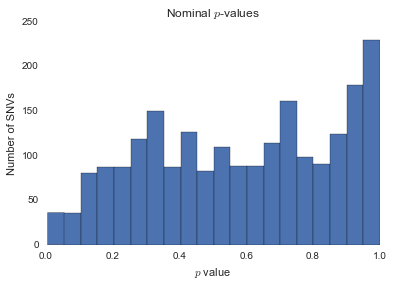

In [526]:
res.PVALUE.hist(bins=20)
plt.title('Nominal $p$ values')
plt.ylabel('Number of SNVs')
plt.xlabel('$p$ value');

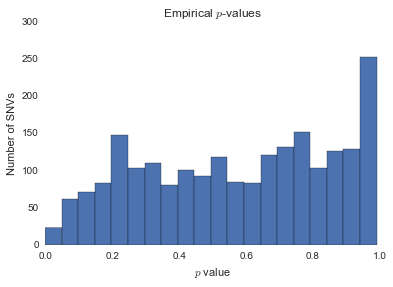

In [528]:
emp_pvals.hist(bins=20)
plt.title('Empirical $p$ values')
plt.ylabel('Number of SNVs')
plt.xlabel('$p$ value');

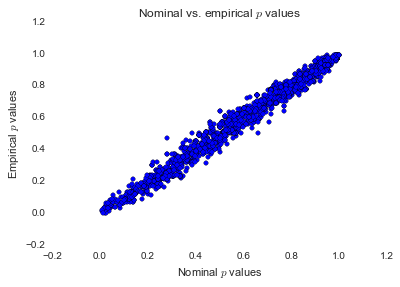

In [529]:
plt.scatter(res.ix[emp_pvals.index, 'PVALUE'], emp_pvals)
plt.title('Nominal vs. empirical $p$ values')
plt.ylabel('Empirical $p$ values')
plt.xlabel('Nominal $p$ values');

I need to figure out how I want to run this on the cluster with permutations. I think 
I'll save the `.epacts.gz` file for the "real" test. Then I'll do all of the permutations
and just save a single file with all of the $p$-values for the permutations. This shouldn't
require too much space. I think that it may make sense to run EPACTS in a directory on RAM
(`/dev/shm`) because it writes temp files.

In [530]:
emp_pvals[emp_pvals < 0.05]

chr3:180556796    0.04
chr3:180622897    0.03
chr3:181063310    0.01
chr3:181063685    0.04
chr3:181257119    0.04
chr3:181449229    0.03
chr3:181455519    0.04
chr3:181469745    0.02
chr3:181510891    0.02
chr3:181511166    0.02
chr3:181511951    0.03
chr3:181637860    0.00
chr3:181948227    0.04
chr3:182157234    0.01
chr3:182157649    0.01
chr3:182318174    0.02
chr3:182321031    0.00
chr3:182329188    0.02
chr3:182332485    0.03
chr3:182334215    0.03
chr3:182393982    0.02
chr3:182394127    0.03
chr3:182397123    0.00
dtype: float64